# Setting up the enviroment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer, AutoProcessor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm

# Load the dataset

In [ ]:
train_df = pd.read_csv("/content/Fake_train.csv")
train_df.head(3)

,text,label
0,നല്ല അവതരണം. സത്യം പുറത്തു വരട്ടെ,Fake
1,Masha Allah,Fake
2,"അന്വേഷണം കഴിയുമ്പോൾ,. C. A. A. യ്ക്ക് എതിരായ ക...",Fake


In [ ]:
val_df = pd.read_csv("/content/Fake_dev.csv")
val_df.head(3)

,text,label
0,Full. Musilm. Verodamum,Fake
1,പക്ഷികളും മൃഗങ്ങളും ഈ ലോകത്ത് സുഖമായി ജീവിക്കു...,Fake
2,ഒരു താടിക്കാരൻ പാത്രം കൊട്ടാൻ പറഞ്ഞപ്പോ .........,original


In [ ]:
test_df = pd.read_csv("/content/test_Fake_test_without_labels.csv")
test_df.head(3)

,Id,text
0,Fake_01,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...
1,Fake_02,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...
2,Fake_03,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...


In [ ]:
TEXT_VAR = "text"
LABEL_VAR = "label"

In [ ]:
# Map text labels to numerical values
label_mapping = {label: idx for idx, label in enumerate(train_df[LABEL_VAR].unique())}
train_df[LABEL_VAR] = train_df[LABEL_VAR].map(label_mapping)  # Change as necessary
val_df[LABEL_VAR] = val_df[LABEL_VAR].map(label_mapping)  # Change as necessary

# Modeling

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
seed = 42
torch.manual_seed(seed)

In [ ]:
# Hyperparameters
model_name = "mdosama39/malayalam-bert-FakeNews-Dravidian"
batch_size = 16
max_length = 786

In [ ]:
# Load Tokenizer and Model
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        transcription = self.df.iloc[idx][TEXT_VAR]
        transcription = transcription if isinstance(transcription, str) else ""
        inputs = self.tokenizer(
            transcription, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt"
        )
        return inputs, self.df.iloc[idx][LABEL_VAR]

## Collect Embeddings

In [ ]:
def extract_text_embeddings(df, save_path, model, tokenizer):
    if os.path.exists(save_path):
        print(f"Embeddings already exist at {save_path}")
        return torch.load(save_path)

    embeddings = {}
    model.eval()
    with torch.no_grad():
        for idx, row in tqdm(df.iterrows(), desc="Extracting text embeddings", total=len(df)):
            transcription = row[TEXT_VAR]
            transcription = transcription if isinstance(transcription, str) else ""

            # Tokenize the text
            inputs = tokenizer(
                transcription, padding="max_length", truncation=True, max_length=512, return_tensors="pt"
            )
            inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU/CPU

            # Extract embeddings
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token embeddings
            embeddings[idx] = cls_embedding.cpu()  # Use the index as the key

    torch.save(embeddings, save_path)
    return embeddings

In [ ]:
train_text_embeddings = extract_text_embeddings(
    train_df, "train_text_embeddings.pt", text_model, text_tokenizer
)
val_text_embeddings = extract_text_embeddings(
    val_df, "val_text_embeddings.pt", text_model, text_tokenizer
)
test_text_embeddings = extract_text_embeddings(
    test_df, "test_text_embeddings.pt", text_model, text_tokenizer
)

Embeddings already exist at train_text_embeddings.pt
Embeddings already exist at val_text_embeddings.pt
Embeddings already exist at test_text_embeddings.pt


## Load Embeddings

In [ ]:
def load_embeddings(embedding_path):
    if os.path.exists(embedding_path):
        print(f"Loading embeddings from {embedding_path}")
        return torch.load(embedding_path)
    else:
        raise FileNotFoundError(f"Embeddings file not found at {embedding_path}")

In [ ]:
train_text_embeddings = load_embeddings("/content/train_text_embeddings.pt")
val_text_embeddings = load_embeddings("/content/val_text_embeddings.pt")
test_text_embeddings = load_embeddings("/content/test_text_embeddings.pt")

Loading embeddings from /content/train_text_embeddings.pt
Loading embeddings from /content/val_text_embeddings.pt
Loading embeddings from /content/test_text_embeddings.pt


## Modeling

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
def prepare_text_embeddings(text_embeddings, df, LABEL_VAR, has_labels=True):
    combined_embeddings = []
    labels = [] if has_labels else None

    for idx, row in df.iterrows():
        # Ensure the index exists in the text embeddings
        if idx in text_embeddings:
            text_embedding = text_embeddings[idx].squeeze()  # Squeeze to remove unnecessary dimensions

            # Add the text embedding to the list
            combined_embeddings.append(text_embedding)

            if has_labels:
                labels.append(row[LABEL_VAR])  # Get the label from the DataFrame

    if has_labels:
        return torch.stack(combined_embeddings), torch.tensor(labels)
    else:
        return torch.stack(combined_embeddings)

In [ ]:
X_train, y_train = prepare_text_embeddings(train_text_embeddings, train_df, LABEL_VAR)
X_val, y_val = prepare_text_embeddings(val_text_embeddings, val_df, LABEL_VAR)
X_test = prepare_text_embeddings(test_text_embeddings, test_df, LABEL_VAR, has_labels=False)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: torch.Size([3257, 768]), Labels: torch.Size([3257])
Validation data shape: torch.Size([815, 768]), Labels: torch.Size([815])
Test data shape: torch.Size([1019, 768])


In [ ]:
# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.2):
        """
        Initialize the MLP model.
        Args:
            input_dim (int): Dimension of the input features.
            hidden_dim (list of int): List of dimensions for hidden layers.
            output_dim (int): Dimension of the output layer.
            dropout_p (float): Dropout probability.
        """
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Hyperparameters
input_dim = X_train.shape[1]
num_classes = len(train_df[LABEL_VAR].unique())
hidden_dim = [786, 512]
output_dim = num_classes
batch_size = 16
num_epochs = 50
learning_rate = 0.0001
dropout_p = 0.2

In [ ]:
# Prepare the data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [ ]:
# Initialize model, loss function, and optimizer
model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    return accuracy, precision, recall, f1

In [ ]:
max_length = train_df['text'].str.len().max()
print(f"Maximum text length: {max_length}")

Maximum text length: 3125


## Train and Val

In [ ]:
# Train and save best model
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def train_and_save_best_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_dir):
    best_f1 = -float('inf')
    best_model_path = None

    for epoch in range(num_epochs):
        model.train() # Indent this line. Start of the loop
        train_loss = 0
        all_train_preds, all_train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) # Remove the squeeze function

            #check if a single sample is passed in as a batch
            if outputs.shape[0] == 1:
                continue

            # Compute loss and backpropagate
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            all_train_preds.extend(preds.cpu().tolist())
            all_train_labels.extend(labels.cpu().tolist())

        # Calculate training metrics
        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(all_train_preds, all_train_labels)

        # Validation phase
        model.eval()
        val_loss = 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs) # Remove the squeeze function
                #check if a single sample is passed in as a batch
                if outputs.shape[0] == 1:
                    continue

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, dim=1)
                all_val_preds.extend(preds.cpu().tolist())
                all_val_labels.extend(labels.cpu().tolist())

        # Calculate validation metrics
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(all_val_preds, all_val_labels)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Prec: {train_precision:.4f}, Rec: {train_recall:.4f}, F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.4f}, Prec: {val_precision:.4f}, "
              f"Rec: {val_recall:.4f}, F1: {val_f1:.4f}")

        # Save the model if it has the best F1 score on validation
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_path = f"{save_dir}/best_model_epoch_{epoch + 1}_f1_{val_f1:.4f}.pth"
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with F1: {val_f1:.4f} at epoch {epoch + 1}")

    return best_model_path

In [ ]:
# Set the directory where the best model will be saved
save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Train the model and save the best model
best_model_path = train_and_save_best_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    save_dir=save_dir
)

print(f"Best model saved at: {best_model_path}")

Epoch 1/50: Train Loss: 0.3886, Train Acc: 0.8815, Prec: 0.8820, Rec: 0.8812, F1: 0.8814 | Val Loss: 0.5171, Val Acc: 0.7877, Prec: 0.7939, Rec: 0.7875, F1: 0.7865
Best model saved with F1: 0.7865 at epoch 1
Epoch 2/50: Train Loss: 0.2823, Train Acc: 0.8962, Prec: 0.8982, Rec: 0.8956, F1: 0.8960 | Val Loss: 0.5001, Val Acc: 0.7988, Prec: 0.8020, Rec: 0.7986, F1: 0.7982
Best model saved with F1: 0.7982 at epoch 2
Epoch 3/50: Train Loss: 0.2806, Train Acc: 0.8975, Prec: 0.8988, Rec: 0.8969, F1: 0.8972 | Val Loss: 0.4802, Val Acc: 0.8025, Prec: 0.8047, Rec: 0.8023, F1: 0.8020
Best model saved with F1: 0.8020 at epoch 3
Epoch 4/50: Train Loss: 0.2788, Train Acc: 0.8984, Prec: 0.8997, Rec: 0.8979, F1: 0.8982 | Val Loss: 0.4797, Val Acc: 0.7988, Prec: 0.8017, Rec: 0.7986, F1: 0.7982
Epoch 5/50: Train Loss: 0.2759, Train Acc: 0.8987, Prec: 0.8998, Rec: 0.8982, F1: 0.8985 | Val Loss: 0.4949, Val Acc: 0.7975, Prec: 0.8013, Rec: 0.7973, F1: 0.7968
Epoch 6/50: Train Loss: 0.2761, Train Acc: 0.900

## Test

In [ ]:
def predict_and_generate_submission(test_loader, best_model_path, submission_file_path):
    # Load the best model with weights_only=True to avoid security warnings
    model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    model.eval()  # Set the model to evaluation mode

    test_predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            # Ensure inputs are converted to a tensor and stacked into a batch if necessary
            if isinstance(inputs, list):
                # Convert each item to tensor using .detach() to avoid the user warning
                inputs = [i.clone().detach().to(device) if isinstance(i, torch.Tensor) else torch.tensor(i).to(device) for i in inputs]
                inputs = torch.stack(inputs)  # Stack them into a batch tensor
            else:
                inputs = inputs.to(device)  # If inputs is already a tensor, move it to device

            outputs = model(inputs).squeeze()

            # Predict binary labels
            _, preds = torch.max(outputs, dim=1)
            test_predictions.extend(preds.tolist())

    # Prepare the submission DataFrame
    submission_df = pd.DataFrame({
        TEXT_VAR: [i for i in test_df[TEXT_VAR]],
        'predictions': test_predictions
    })

    # Save the predictions to a CSV file
    submission_df.to_csv(submission_file_path, index=False)
    print(f"Submission file saved to {submission_file_path}")

    return submission_df

In [ ]:
submission_file_path = "submission.csv"
submission_df = predict_and_generate_submission(test_loader=test_loader, best_model_path=best_model_path, submission_file_path=submission_file_path)

Submission file saved to submission.csv


In [ ]:
submission_df.head()

,text,predictions
0,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...,0
1,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...,1
2,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...,0
3,Shame for entire Woman&#39;s of Kerala,1
4,135 code janaghal andhu wide business cheythal...,0


# Confusion Matrix

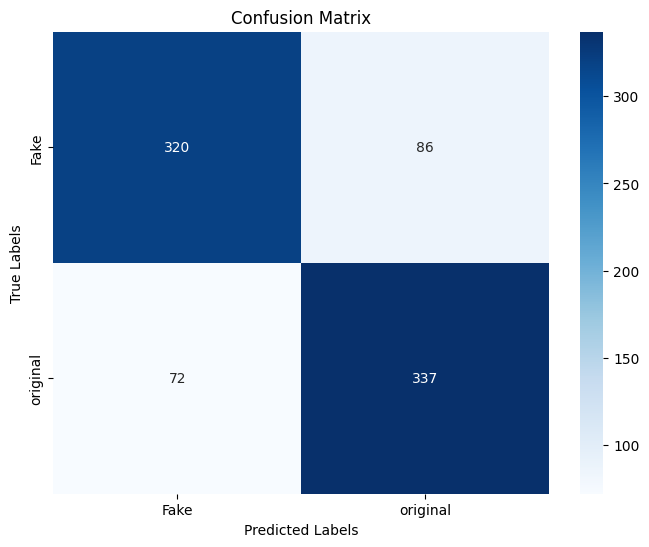

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Load the best model
best_model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)
best_model.load_state_dict(torch.load(best_model_path))

# Plot confusion matrix for validation data
plot_confusion_matrix(best_model, val_loader, device)


# Printing Wrong Prediction

In [ ]:

import torch

# Ensure everything is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_val)
    y_pred = torch.argmax(y_pred_logits, dim=1)

# Convert tensors to CPU
y_pred_list = y_pred.cpu().numpy()
y_true_list = y_val.cpu().numpy()

# Identify incorrect predictions
wrong_indices = [i for i in range(len(y_true_list)) if y_pred_list[i] != y_true_list[i]]

# Print some incorrect predictions with actual text
print("\nSome incorrect predictions:")
for i in wrong_indices[:10]:  # Print first 10 wrong predictions
    text_sample = val_df.iloc[i]['text']  # Assuming your validation dataframe has a 'text' column
    print(f"Text: {text_sample}\nActual Label: {y_true_list[i]}, Predicted: {y_pred_list[i]}\n{'-'*80}")




Some incorrect predictions:
Text: Ethu kondu alle  evare andham commi annu vilikunathu
Actual Label: 1, Predicted: 0
--------------------------------------------------------------------------------
Text: Kandagasheni &quot;SHAAPAM&quot; kondepovu .....
Actual Label: 0, Predicted: 1
--------------------------------------------------------------------------------
Text: Evarku yandu avam
Actual Label: 1, Predicted: 0
--------------------------------------------------------------------------------
Text: <br>പാർട്ടിയുടെ പേരുകളിൽ മാത്രമേ മാറ്റമൊള്ളൂ...കാലഹരണപ്പെട്ട ആദർശങ്ങളുടെ പേരിൽ ഇപ്പോഴും പാവപ്പെട്ടവരുടെ ചോര ഊറ്റുന്ന.....പ്രസംഗവും പ്രവർത്തിയുമായി ബന്ധമില്ലാത്ത ഇവരിൽനിന്ന് നല്ല കാര്യങ്ങൾ പ്രതീക്ഷിച്ചെങ്കിൽ അത് ജനത്തിന്റെ തെറ്റാണ്...ജനത്തിന്റെ മാത്രം.
Actual Label: 1, Predicted: 0
--------------------------------------------------------------------------------
Text: കിറ്റപ്പന്റെ പാർട്ടിക്ക് നല്ല പൈസ ഉണ്ടാക്കാൻ പറ്റിയില്ലേ, ഭരണം 2മതും കിട്ടിയില്ലേ 😜ബായ് ബായ് സഹായിച്ചതല്ലേ ബായ് 😜😜😜😜😜
Actual 